In [24]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import os
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Install and import TSFEL for feature extraction
try:
    import tsfel
except ImportError:
    print("Installing TSFEL...")
    import subprocess
    subprocess.check_call(["pip", "install", "tsfel"])
    import tsfel

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [25]:
# Load Dataset 
class HARDataLoader:
    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)
        self.activity_labels = {
            'LAYING': 0,
            'SITTING': 1, 
            'STANDING': 2,
            'WALKING': 3,
            'WALKING_DOWNSTAIRS': 4,
            'WALKING_UPSTAIRS': 5
        }
        self.label_to_activity = {v: k for k, v in self.activity_labels.items()}
        
    def load_raw_data(self, data_type='Train'):
        data_path = self.dataset_path / data_type
        
        X_data = []
        y_data = []
        subjects = []
        
        for activity, label in self.activity_labels.items():
            activity_path = data_path / activity
            if not activity_path.exists():
                print(f"Warning: {activity_path} does not exist")
                continue
                
            csv_files = list(activity_path.glob("*.csv"))
            print(f"Found {len(csv_files)} files for {activity}")
            
            for csv_file in csv_files:
                try:
                    subject_id = int(csv_file.stem.split('_')[1])
                    df = pd.read_csv(csv_file)

                    if len(df) >= 500:
                        acc_data = df.iloc[:500, :3].values 
                        flattened_data = acc_data.flatten()
                        
                        X_data.append(flattened_data)
                        y_data.append(label)
                        subjects.append(subject_id)
                    else:
                        print(f"Warning: {csv_file} has less than 500 samples ({len(df)})")
                        
                except Exception as e:
                    print(f"Error loading {csv_file}: {e}")
                    
        return np.array(X_data), np.array(y_data), np.array(subjects)
    
    def get_activity_name(self, label):
        """Convert numeric label to activity name"""
        return self.label_to_activity.get(label, f"Unknown_{label}")

dataset_path = "HAR/Combined"  # Path points to Combined folder with Train/Test subfolders
data_loader = HARDataLoader(dataset_path)

print("Data loader initialized successfully!")
print(f"Activity labels: {data_loader.activity_labels}")

Data loader initialized successfully!
Activity labels: {'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5}


In [26]:
# Load training, test data
try:
    X_train_raw, y_train, subjects_train = data_loader.load_raw_data('Train')
    X_test_raw, y_test, subjects_test = data_loader.load_raw_data('Test')
    
    print(f"Raw data shapes:")
    print(f"Train: X={X_train_raw.shape}, y={y_train.shape}")
    print(f"Test: X={X_test_raw.shape}, y={y_test.shape}")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please make sure the dataset path is correct and data files exist.")

Found 21 files for LAYING
Found 21 files for SITTING
Found 21 files for STANDING
Found 21 files for WALKING
Found 21 files for WALKING_DOWNSTAIRS
Found 21 files for WALKING_UPSTAIRS
Found 21 files for WALKING
Found 21 files for WALKING_DOWNSTAIRS
Found 21 files for WALKING_UPSTAIRS
Found 9 files for LAYING
Found 9 files for SITTING
Found 9 files for STANDING
Found 9 files for WALKING
Found 9 files for WALKING_DOWNSTAIRS
Found 9 files for WALKING_UPSTAIRS
Raw data shapes:
Train: X=(126, 1500), y=(126,)
Test: X=(54, 1500), y=(54,)
Found 9 files for LAYING
Found 9 files for SITTING
Found 9 files for STANDING
Found 9 files for WALKING
Found 9 files for WALKING_DOWNSTAIRS
Found 9 files for WALKING_UPSTAIRS
Raw data shapes:
Train: X=(126, 1500), y=(126,)
Test: X=(54, 1500), y=(54,)


In [27]:
# Utility functions for the assignment

def plot_sample_waveforms(X_data, y_data, data_loader, title="Sample Waveforms"):
    """
    Plot sample waveforms for each activity class
    """
    fig, axes = plt.subplots(6, 1, figsize=(10, 25))
    axes = axes.flatten()
    
    for i, (activity, label) in enumerate(data_loader.activity_labels.items()):
        # Find first sample of this activity
        activity_indices = np.where(y_data == label)[0]
        if len(activity_indices) > 0:
            sample_idx = activity_indices[0]
            sample_data = X_data[sample_idx].reshape(500, 3)  # Reshape to (time, 3_axes)
            
            # Plot the 3 axes
            time = np.arange(500) / 50.0  # Convert to seconds (50Hz sampling)
            axes[i].plot(time, sample_data[:, 0], label='X-axis', alpha=0.7)
            axes[i].plot(time, sample_data[:, 1], label='Y-axis', alpha=0.7)
            axes[i].plot(time, sample_data[:, 2], label='Z-axis', alpha=0.7)
            
            axes[i].set_title(f'{activity}')
            axes[i].set_xlabel('Time (s)')
            axes[i].set_ylabel('Acceleration')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].set_title(f'{activity} (No data)')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def calculate_total_acceleration(X_raw):
    """
    Calculate total acceleration from raw accelerometer data
    """
    # Reshape to (samples, time, 3_axes)
    X_reshaped = X_raw.reshape(X_raw.shape[0], 500, 3)
    
    # Calculate total acceleration for each time step
    total_acc = np.sqrt(np.sum(X_reshaped**2, axis=2))
    
    return total_acc

def evaluate_model(model, X_test, y_test, class_names):
    """
    Evaluate model and return metrics
    """
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return accuracy, precision, recall, f1, cm


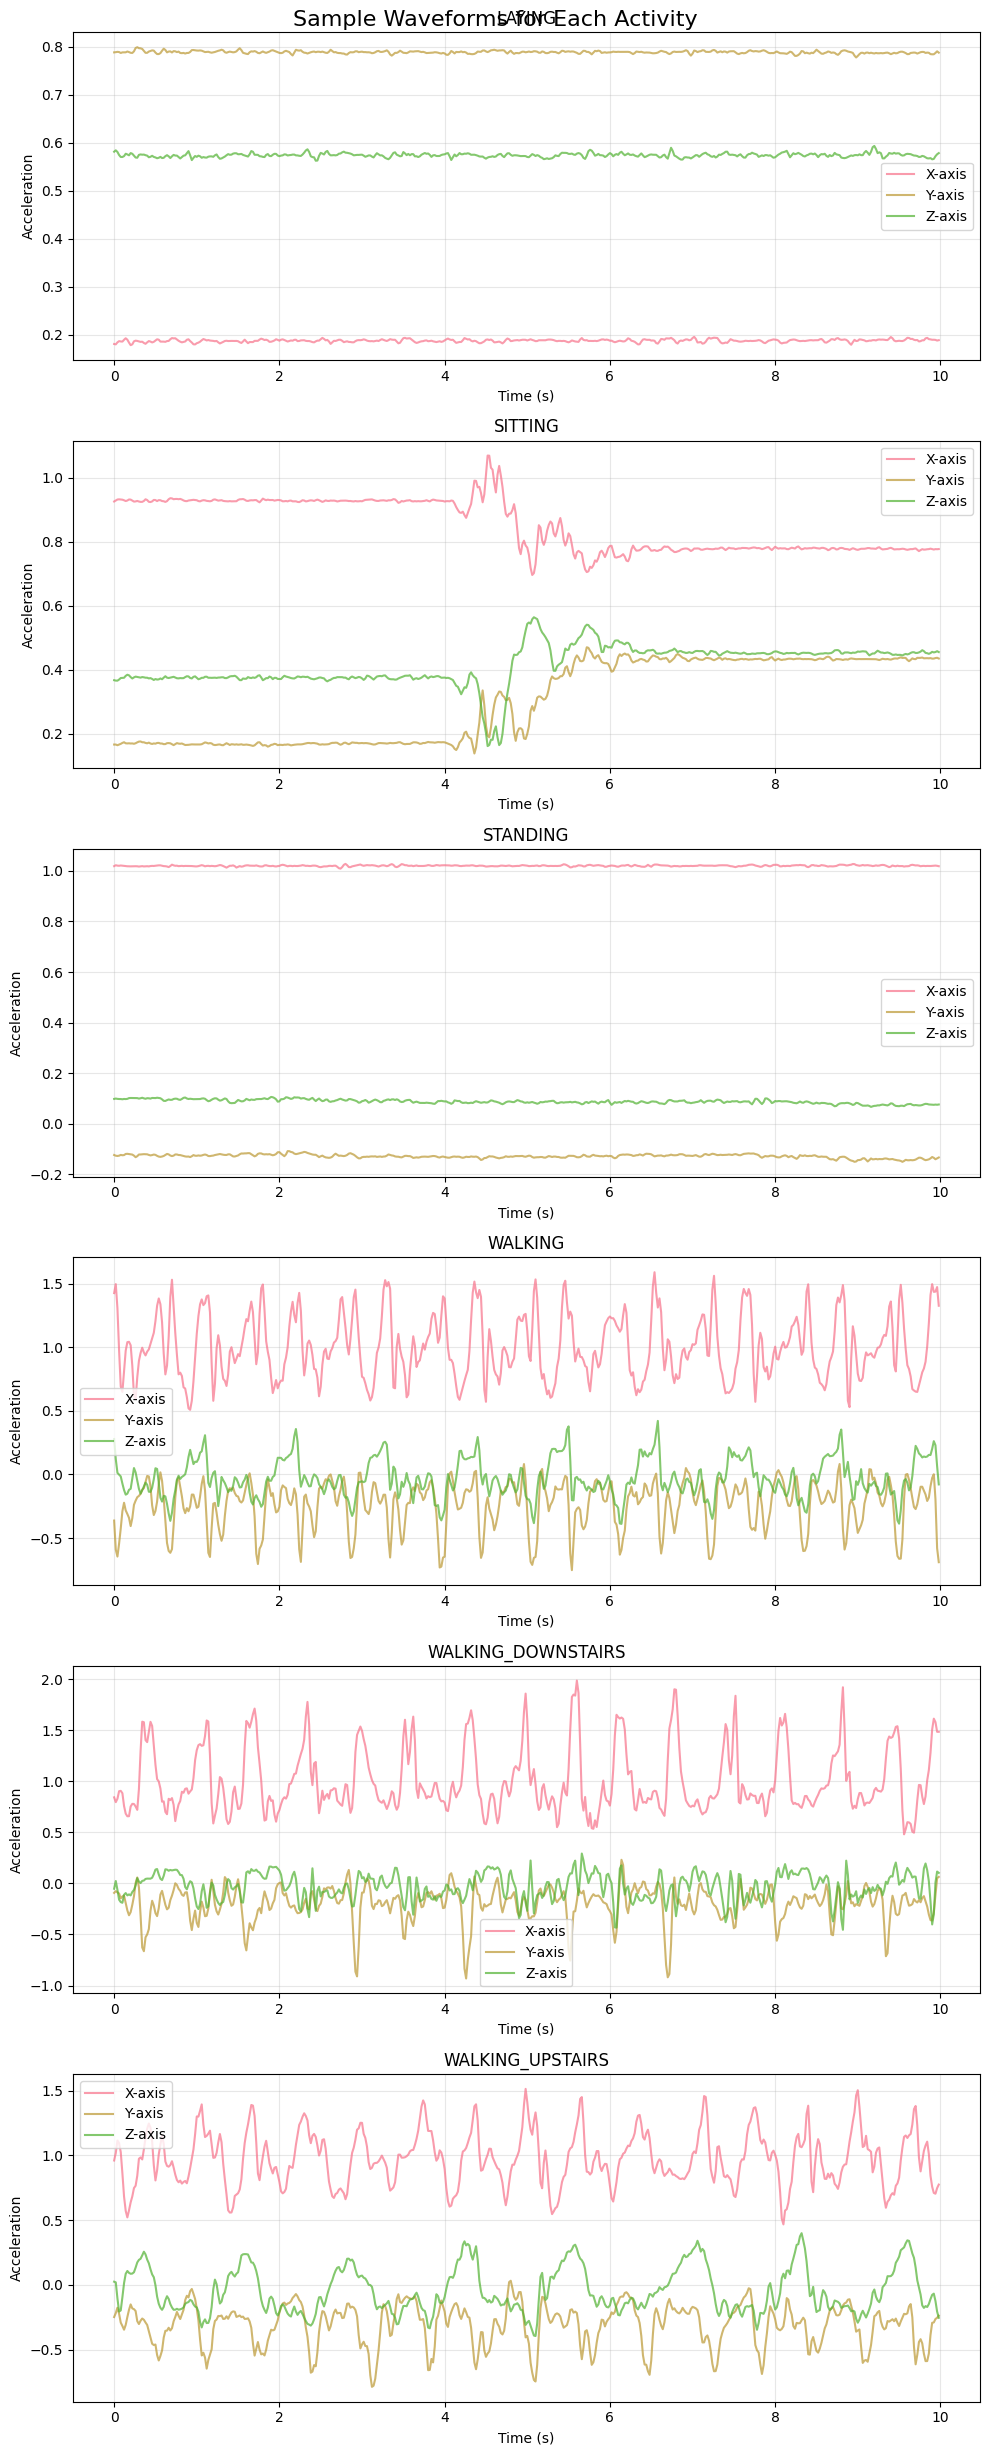

In [28]:
# Question 1: Plot waveforms for each activity class
plot_sample_waveforms(X_train_raw, y_train, data_loader, "Sample Waveforms for Each Activity")

From the Plots we can observe that Dynamic Activities like Walking, Walking Upstairs and Walking Downstairs have component of acceleration in all three axes (x, y, z). In contrast, Static Activities like Sitting and Standing show less variation in acceleration, indicating less movement. This is consistent with our expectations, as dynamic activities typically involve more movement and changes in body position. Yes I believe that model can distinguish well in between static and dynamic activities but distinction between different dynamic activities might be challenging due to their similar patterns.

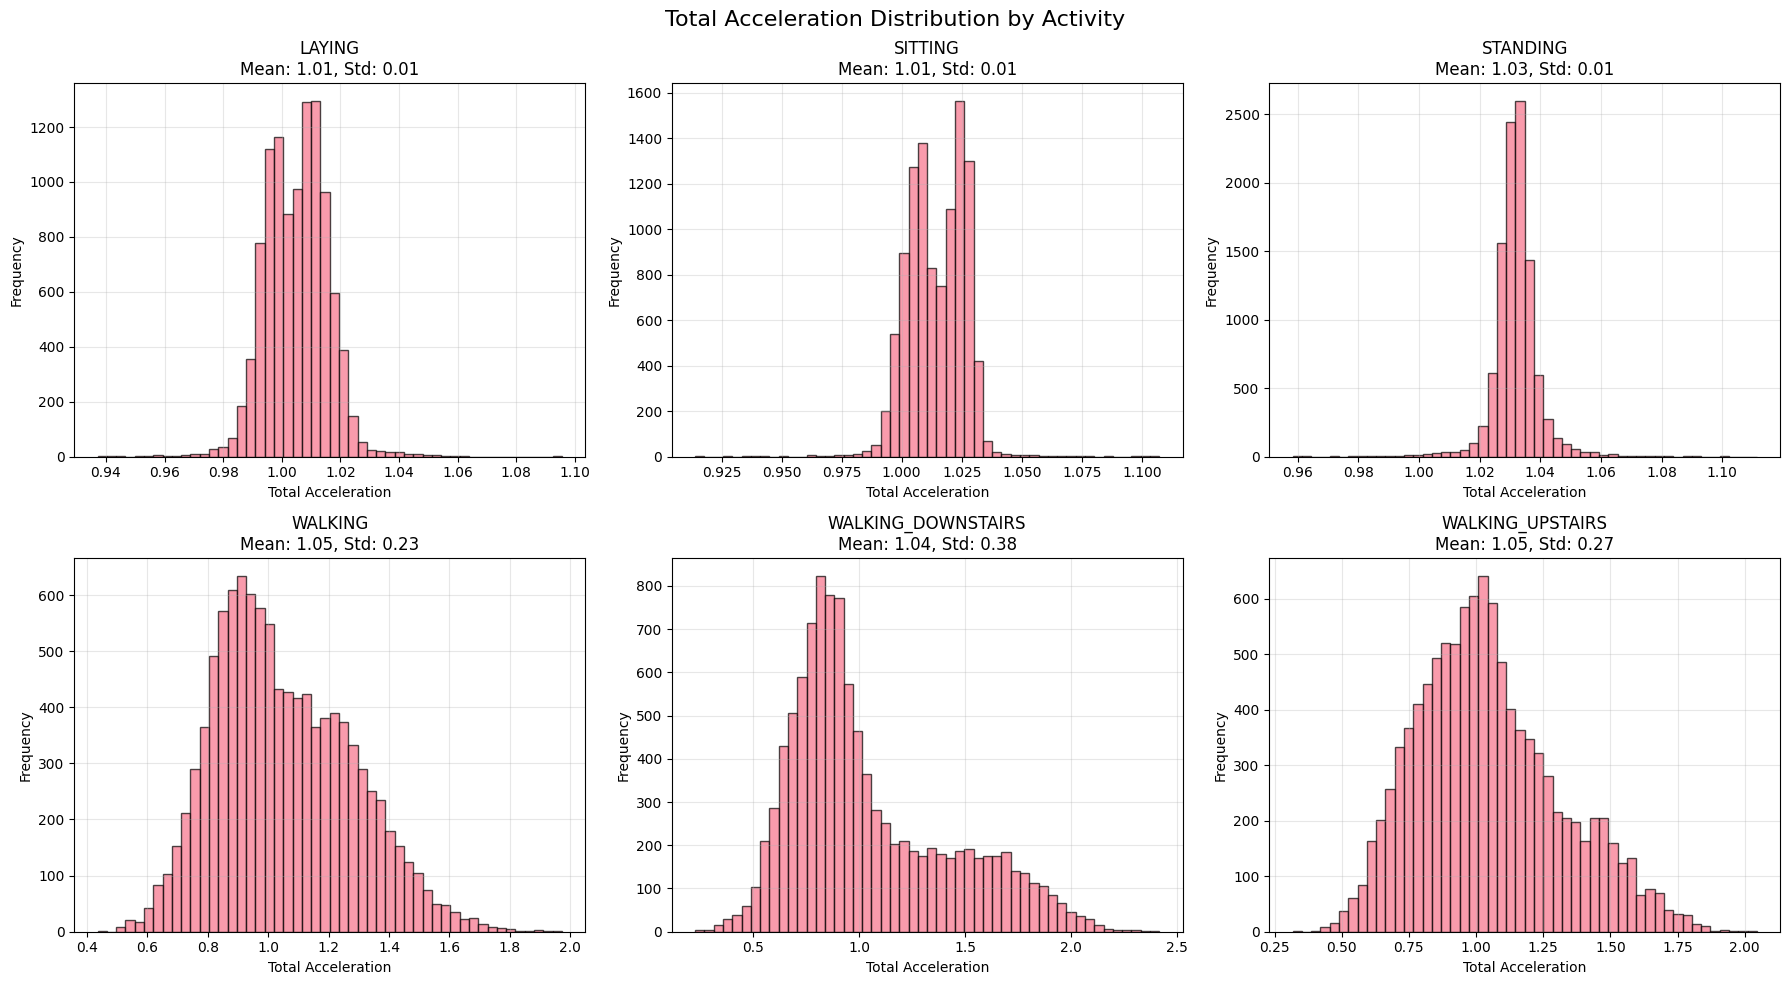


Total Acceleration Analysis:
Activity		Mean		Std		Variance
------------------------------------------------------------
LAYING              	1.005		0.011		0.000
SITTING             	1.014		0.012		0.000
STANDING            	1.032		0.008		0.000
WALKING             	1.050		0.226		0.051
WALKING_DOWNSTAIRS  	1.041		0.378		0.143
WALKING_UPSTAIRS    	1.046		0.268		0.072


In [29]:
# Question 2: Static vs Dynamic Activities Analysis
total_acc_train = calculate_total_acceleration(X_train_raw)

# Calculate statistics for each activity
activity_stats = {}
for activity, label in data_loader.activity_labels.items():
    activity_indices = np.where(y_train == label)[0]
    if len(activity_indices) > 0:
        activity_total_acc = total_acc_train[activity_indices]
        activity_stats[activity] = {
            'mean': np.mean(activity_total_acc),
            'std': np.std(activity_total_acc),
            'variance': np.var(activity_total_acc)
        }

# Plot total acceleration distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (activity, label) in enumerate(data_loader.activity_labels.items()):
    activity_indices = np.where(y_train == label)[0]
    if len(activity_indices) > 0:
        activity_total_acc = total_acc_train[activity_indices]
        
        # Plot histogram of total acceleration
        axes[i].hist(activity_total_acc.flatten(), bins=50, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{activity}\nMean: {activity_stats[activity]["mean"]:.2f}, Std: {activity_stats[activity]["std"]:.2f}')
        axes[i].set_xlabel('Total Acceleration')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

plt.suptitle('Total Acceleration Distribution by Activity', fontsize=16)
plt.tight_layout()
plt.show()

# Analysis
print("\nTotal Acceleration Analysis:")
print("Activity\t\tMean\t\tStd\t\tVariance")
print("-" * 60)
for activity, stats in activity_stats.items():
    print(f"{activity:<20}\t{stats['mean']:.3f}\t\t{stats['std']:.3f}\t\t{stats['variance']:.3f}")

We can easily threshold the data based on static and dynamic activities by saying that if the acceleration magnitude is below a certain threshold, we consider it static, and if it's above that threshold, we consider it dynamic, And that magnitude is greater than 0.011 and smaller than 0.226

Total acceleration shape: (126, 500)


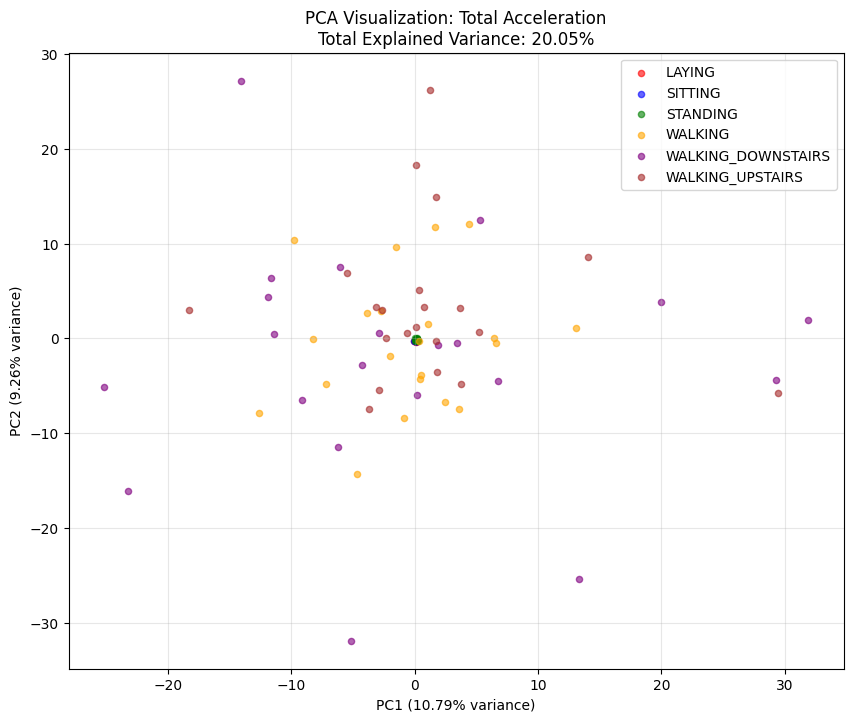

In [41]:
# Question 3: PCA Visualization 

def perform_pca_analysis(features, labels, title, feature_names=None):
    """Perform PCA and create visualization"""
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Apply PCA
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)
    
    # Plot results
    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
    
    for i, (activity, label) in enumerate(data_loader.activity_labels.items()):
        mask = labels == label
        if np.any(mask):
            plt.scatter(features_pca[mask, 0], features_pca[mask, 1], 
                       c=colors[i], label=activity, alpha=0.6, s=20)
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'{title}\nTotal Explained Variance: {sum(pca.explained_variance_ratio_):.2%}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return pca, features_pca


total_acc_train = calculate_total_acceleration(X_train_raw)
print(f"Total acceleration shape: {total_acc_train.shape}")

pca_total, _ = perform_pca_analysis(
    total_acc_train, y_train, 
    "PCA Visualization: Total Acceleration"
)

Extracting TSFEL features: 12 samples per class...
Extracted 72 valid features
Class distribution: [12 12 12 12 12 12]
Extracting TSFEL features: 3 samples per class...
Extracted 72 valid features
Class distribution: [12 12 12 12 12 12]
Extracting TSFEL features: 3 samples per class...
Extracted 18 valid features
Class distribution: [3 3 3 3 3 3]
TSFEL Train shape: (72, 468)
TSFEL Test shape: (18, 468)
Extracted 18 valid features
Class distribution: [3 3 3 3 3 3]
TSFEL Train shape: (72, 468)
TSFEL Test shape: (18, 468)


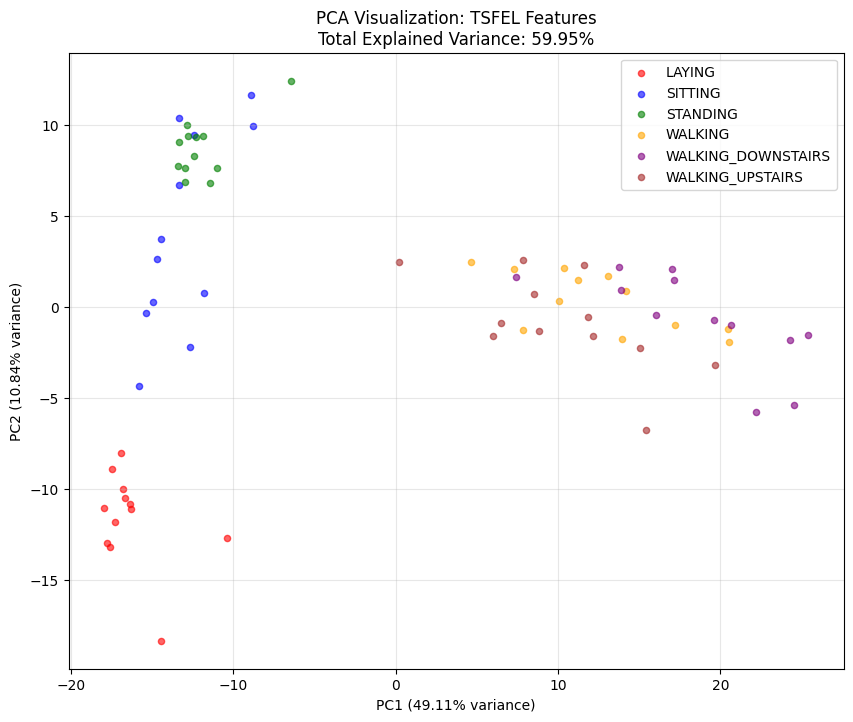

In [ ]:
# Question 3: PCA Visualization TSFEL Features

# Configure TSFEL
cfg = tsfel.get_features_by_domain()

def extract_tsfel_features(X_raw, y_labels, max_samples=None):
    """Extract TSFEL features from raw data with balanced sampling"""
    features = []
    labels = []
    
    # Get balanced samples per class
    unique_labels = np.unique(y_labels)
    samples_per_class = max_samples // len(unique_labels) if max_samples else 10
    
    print(f"Extracting TSFEL features: {samples_per_class} samples per class...")
    
    for label in unique_labels:
        # Get indices for this activity
        class_indices = np.where(y_labels == label)[0]
        # Take up to samples_per_class samples
        selected_indices = class_indices[:samples_per_class]
        
        for idx in selected_indices:
            sample = X_raw[idx].reshape(500, 3)
            sample_df = pd.DataFrame(sample, columns=['acc_x', 'acc_y', 'acc_z'])
            
            try:
                feat = tsfel.time_series_features_extractor(cfg, sample_df, verbose=0)
                features.append(feat.values.flatten())
                labels.append(y_labels[idx])
            except Exception as e:
                print(f"Error extracting features for sample {idx}: {e}")
                continue
    
    if len(features) > 0:
        features = np.array(features)
        labels = np.array(labels)
        
        # Remove samples with non-finite values
        finite_mask = np.isfinite(features).all(axis=1)
        features_clean = features[finite_mask]
        labels_clean = labels[finite_mask]
        
        print(f"Extracted {len(features_clean)} valid features")
        print(f"Class distribution: {np.bincount(labels_clean)}")
        
        return features_clean, labels_clean
    return None, None

X_tsfel_train, y_tsfel_train = extract_tsfel_features(X_train_raw, y_train, max_samples=72)

X_tsfel_test, y_tsfel_test = extract_tsfel_features(X_test_raw, y_test, max_samples=18)

if X_tsfel_train is not None and X_tsfel_test is not None:
    print(f"TSFEL Train shape: {X_tsfel_train.shape}")
    print(f"TSFEL Test shape: {X_tsfel_test.shape}")
    
    # Use train data for PCA visualization
    pca_tsfel, _ = perform_pca_analysis(
        X_tsfel_train, y_tsfel_train,
        "PCA Visualization: TSFEL Features"
    )
else:
    print("Could not extract TSFEL features")

Using raw accelerometer data directly for PCA...
Raw data shape: (126, 1500)


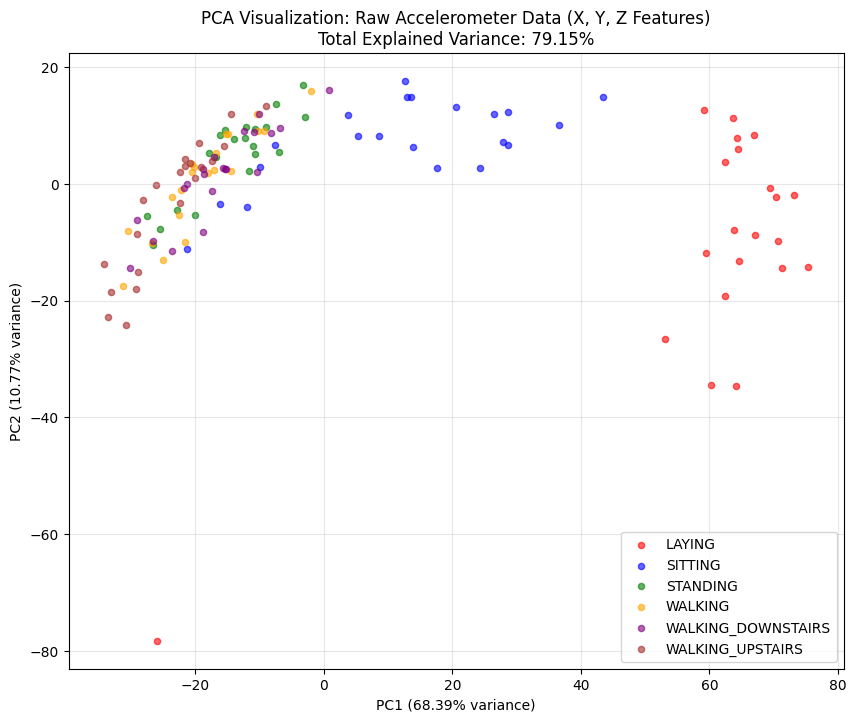

In [47]:
# Question 3: PCA on Raw Accelerometer Data

print("Using raw accelerometer data directly for PCA...")
print(f"Raw data shape: {X_train_raw.shape}")

pca_raw, _ = perform_pca_analysis(
    X_train_raw, y_train,
    "PCA Visualization: Raw Accelerometer Data (X, Y, Z Features)"
)

## PCA comparison: Total Acceleration vs TSFEL vs Dataset Features

Although PCA on raw accelerometer data explains the most variance, the activities overlap heavily, making it less useful for interpretation. In contrast, PCA on TSFEL features produces clearer clusters of activities, even with slightly lower explained variance, showing that feature extraction improves separability. PCA on total acceleration performs worst, as it explains little variance and shows no clear clustering. Therefore, TSFEL features provide the best representation for visualizing and distinguishing between activities.

## Part 4: Correlation analysis (TSFEL and dataset-derived features)

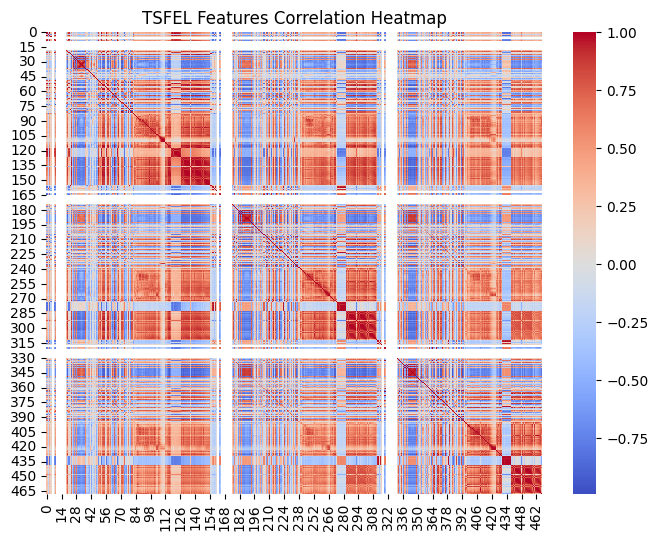

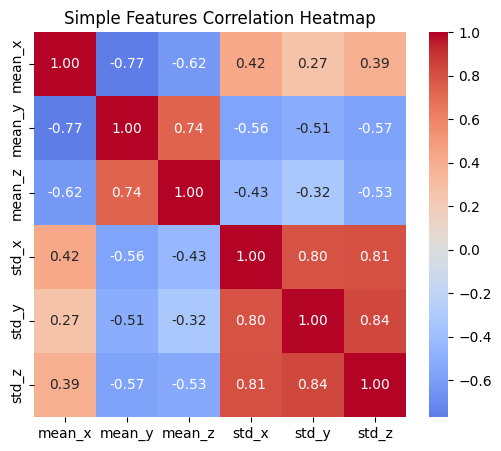

In [48]:
# Correlation analysis
def list_high_corr_pairs(corr_df, threshold=0.9):
    pairs = []
    cols = corr_df.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            val = corr_df.iloc[i, j]
            if np.isfinite(val) and abs(val) >= threshold:
                pairs.append((cols[i], cols[j], float(val)))
    return sorted(pairs, key=lambda x: -abs(x[2]))

# TSFEL features correlation
if 'X_tsfel_train' in globals() and X_tsfel_train is not None:
    tsfel_df = pd.DataFrame(X_tsfel_train)
    corr_tsfel = tsfel_df.corr(numeric_only=True)
    pairs_tsfel = list_high_corr_pairs(corr_tsfel)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_tsfel, cmap='coolwarm', center=0, cbar=True)
    plt.title('TSFEL Features Correlation Heatmap')
    plt.show()
else:
    pairs_tsfel = []

# Simple features correlation
Xr = X_train_raw.reshape(len(X_train_raw), 500, 3)
feat_simple = np.array([[seg[:,0].mean(), seg[:,1].mean(), seg[:,2].mean(), 
                         seg[:,0].std(), seg[:,1].std(), seg[:,2].std()] 
                        for seg in Xr])
simple_df = pd.DataFrame(feat_simple, columns=['mean_x','mean_y','mean_z','std_x','std_y','std_z'])
corr_simple = simple_df.corr(numeric_only=True)
pairs_simple = list_high_corr_pairs(corr_simple)

plt.figure(figsize=(6, 5))
sns.heatmap(corr_simple, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Simple Features Correlation Heatmap')
plt.show()

# Task 2: Decision Trees for Human Activity Recognition

Raw Accelerometer Data:
Accuracy: 0.685, Precision: 0.683, Recall: 0.685


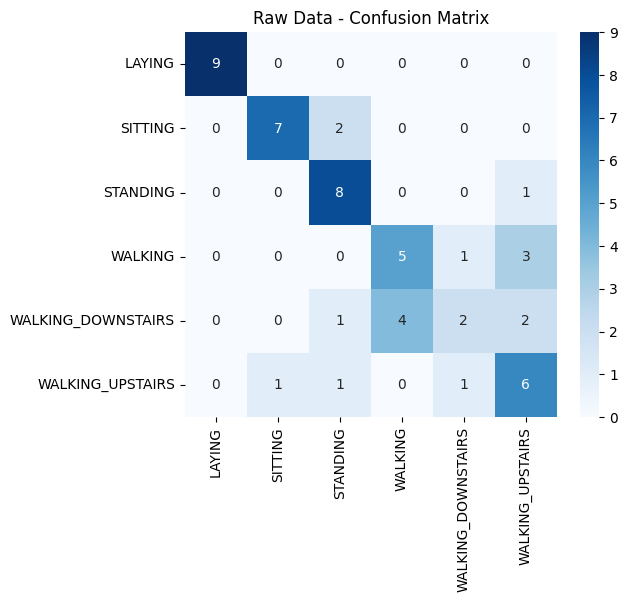


TSFEL Features (train=72, test=18):
Accuracy: 0.778, Precision: 0.806, Recall: 0.778

Accuracy: 0.778, Precision: 0.806, Recall: 0.778


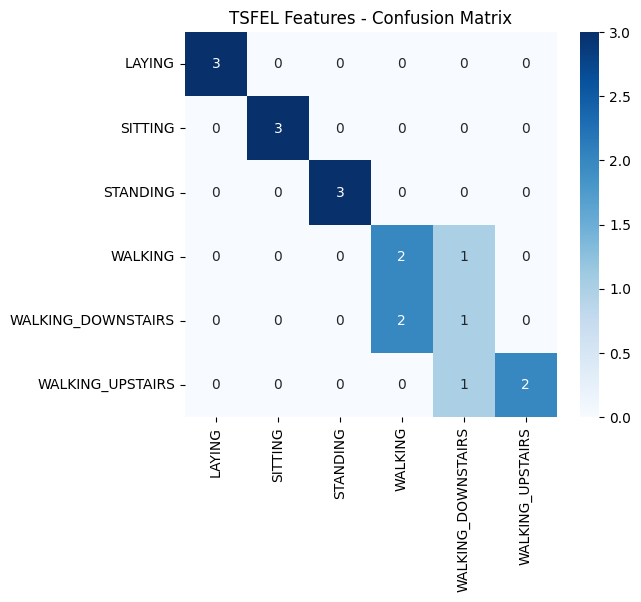


Simple Features:
Accuracy: 0.722, Precision: 0.736, Recall: 0.722

Accuracy: 0.722, Precision: 0.736, Recall: 0.722


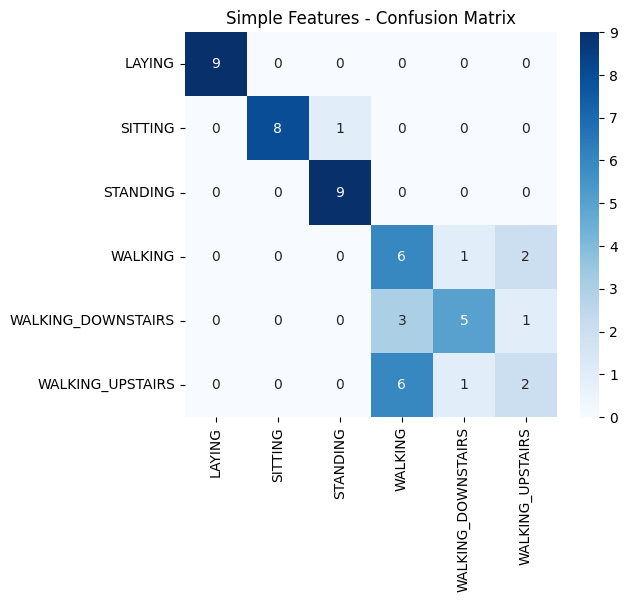


=== COMPARISON ===
Raw model accuracy: 0.685
Tsfel model accuracy: 0.778
Simple model accuracy: 0.722

Best model: Tsfel (Accuracy: 0.778)


In [ ]:
# Decision Tree Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = list(data_loader.activity_labels.keys())
results = {}

# 1. Raw accelerometer data
dt_raw = DecisionTreeClassifier(random_state=42)
dt_raw.fit(X_train_raw, y_train)
y_pred_raw = dt_raw.predict(X_test_raw)

acc_raw = accuracy_score(y_test, y_pred_raw)
prec_raw, rec_raw, f1_raw, _ = precision_recall_fscore_support(y_test, y_pred_raw, average='weighted')
cm_raw = confusion_matrix(y_test, y_pred_raw)

print("Raw Accelerometer Data:")
print(f"Accuracy: {acc_raw:.3f}, Precision: {prec_raw:.3f}, Recall: {rec_raw:.3f}")
plt.figure(figsize=(6,5))
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Raw Data - Confusion Matrix')
plt.show()

results['raw'] = acc_raw

# 2. TSFEL features (proper train/test split)
if 'X_tsfel_train' in globals() and X_tsfel_train is not None and 'X_tsfel_test' in globals() and X_tsfel_test is not None:
    dt_tsfel = DecisionTreeClassifier(random_state=42)
    dt_tsfel.fit(X_tsfel_train, y_tsfel_train)
    y_pred_tsfel = dt_tsfel.predict(X_tsfel_test)
    
    acc_tsfel = accuracy_score(y_tsfel_test, y_pred_tsfel)
    prec_tsfel, rec_tsfel, f1_tsfel, _ = precision_recall_fscore_support(y_tsfel_test, y_pred_tsfel, average='weighted')
    cm_tsfel = confusion_matrix(y_tsfel_test, y_pred_tsfel)
    
    print(f"\nTSFEL Features (train={len(X_tsfel_train)}, test={len(X_tsfel_test)}):")
    print(f"Accuracy: {acc_tsfel:.3f}, Precision: {prec_tsfel:.3f}, Recall: {rec_tsfel:.3f}")
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_tsfel, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('TSFEL Features - Confusion Matrix')
    plt.show()
    
    results['tsfel'] = acc_tsfel
else:
    print("TSFEL features not available")

# 3. Simple derived features
dt_simple = DecisionTreeClassifier(random_state=42)
dt_simple.fit(feat_simple, y_train)

# Create test features 
X_test_reshaped = X_test_raw.reshape(len(X_test_raw), 500, 3)
feat_test = np.array([[seg[:,0].mean(), seg[:,1].mean(), seg[:,2].mean(), 
                       seg[:,0].std(), seg[:,1].std(), seg[:,2].std()] 
                      for seg in X_test_reshaped])

y_pred_simple = dt_simple.predict(feat_test)
acc_simple = accuracy_score(y_test, y_pred_simple)
prec_simple, rec_simple, f1_simple, _ = precision_recall_fscore_support(y_test, y_pred_simple, average='weighted')
cm_simple = confusion_matrix(y_test, y_pred_simple)

print("\nSimple Features:")
print(f"Accuracy: {acc_simple:.3f}, Precision: {prec_simple:.3f}, Recall: {rec_simple:.3f}")
plt.figure(figsize=(6,5))
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Simple Features - Confusion Matrix')
plt.show()

results['simple'] = acc_simple

# Results comparison
print(f"\n COMPARISON")
for model, acc in results.items():
    print(f"{model.capitalize()} model accuracy: {acc:.3f}")

best_model = max(results, key=results.get)
print(f"\nBest model: {best_model.capitalize()} (Accuracy: {results[best_model]:.3f})")

## Decision Tree Depth Analysis
Train Decision Tree with varying depths (2-8) using all three feature methods and compare performance.

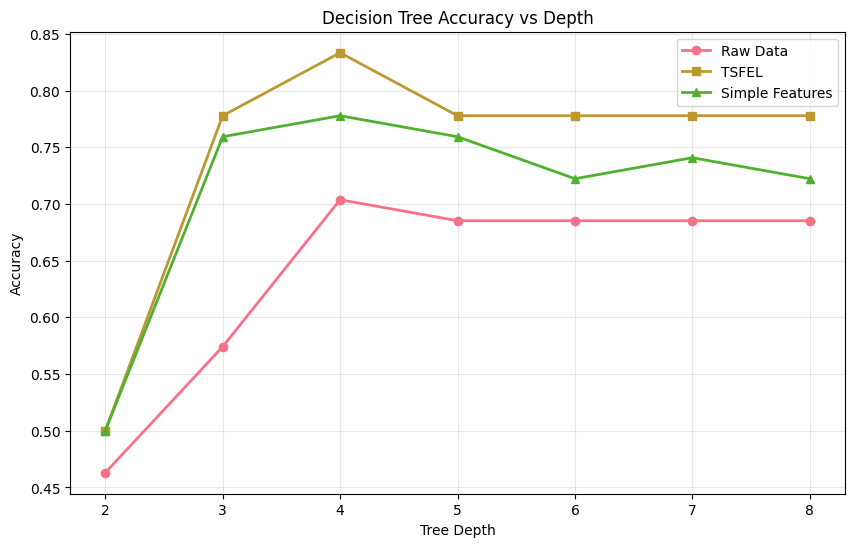

Best Depths:
Raw: 4 (Acc: 0.704)
TSFEL: 4 (Acc: 0.833)
Simple: 4 (Acc: 0.778)


In [52]:
# Simplified Decision Tree Depth Analysis (2-8)
depths = range(2, 9)
results_depth = {'raw': [], 'tsfel': [], 'simple': []}

for depth in depths:
    # Raw data
    dt_raw = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_raw.fit(X_train_raw, y_train)
    acc_raw = accuracy_score(y_test, dt_raw.predict(X_test_raw))
    results_depth['raw'].append(acc_raw)
    
    # TSFEL features
    if 'X_tsfel_train' in globals() and X_tsfel_train is not None:
        dt_tsfel = DecisionTreeClassifier(max_depth=depth, random_state=42)
        dt_tsfel.fit(X_tsfel_train, y_tsfel_train)
        acc_tsfel = accuracy_score(y_tsfel_test, dt_tsfel.predict(X_tsfel_test))
        results_depth['tsfel'].append(acc_tsfel)
    else:
        results_depth['tsfel'].append(0)
    
    # Simple features
    dt_simple = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_simple.fit(feat_simple, y_train)
    acc_simple = accuracy_score(y_test, dt_simple.predict(feat_test))
    results_depth['simple'].append(acc_simple)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(depths, results_depth['raw'], 'o-', label='Raw Data', linewidth=2)
if any(acc > 0 for acc in results_depth['tsfel']):
    plt.plot(depths, results_depth['tsfel'], 's-', label='TSFEL', linewidth=2)
plt.plot(depths, results_depth['simple'], '^-', label='Simple Features', linewidth=2)
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Depth')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Best depths
print("Best Depths:")
print(f"Raw: {depths[np.argmax(results_depth['raw'])]} (Acc: {max(results_depth['raw']):.3f})")
if any(acc > 0 for acc in results_depth['tsfel']):
    print(f"TSFEL: {depths[np.argmax(results_depth['tsfel'])]} (Acc: {max(results_depth['tsfel']):.3f})")
print(f"Simple: {depths[np.argmax(results_depth['simple'])]} (Acc: {max(results_depth['simple']):.3f})")

## Model Performance Analysis by Participants and Activities
Analyze where the model performs poorly and identify potential reasons.

=== PERFORMANCE BY ACTIVITY ===
Activity		Precision	Recall		F1-Score
------------------------------------------------------------
LAYING              	1.000		1.000		1.000
SITTING             	1.000		0.889		0.941
STANDING            	0.900		1.000		0.947
WALKING             	0.400		0.667		0.500
WALKING_DOWNSTAIRS  	0.714		0.556		0.625
WALKING_UPSTAIRS    	0.400		0.222		0.286


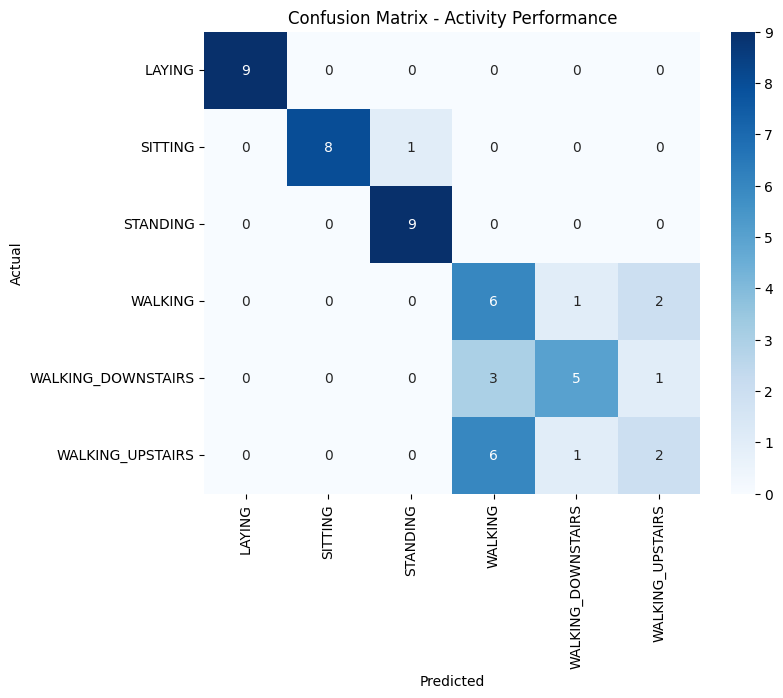


Worst performing activities (F1 < 0.8): ['WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']


In [55]:
# Simplified Performance Analysis by Activity
dt_best = DecisionTreeClassifier(random_state=42)
dt_best.fit(feat_simple, y_train)
y_pred = dt_best.predict(feat_test)

# Get metrics per activity
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

print("=== PERFORMANCE BY ACTIVITY ===")
print("Activity\t\tPrecision\tRecall\t\tF1-Score")
print("-" * 60)
for activity in class_names:
    if activity in report:
        prec = report[activity]['precision']
        rec = report[activity]['recall']
        f1 = report[activity]['f1-score']
        print(f"{activity:<20}\t{prec:.3f}\t\t{rec:.3f}\t\t{f1:.3f}")

# Show confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Activity Performance')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Identify worst performing activities
worst_activities = []
for activity in class_names:
    if activity in report and report[activity]['f1-score'] < 0.8:
        worst_activities.append(activity)

print(f"\nWorst performing activities (F1 < 0.8): {worst_activities}")

Walking upstairs is worst performing activity but similarly walking downstairs and walking also has low perfomance due to variability of sensor data 

# Task 3: Data Collection in the Wild
Analysis of collected smartphone accelerometer data using trained UCI-HAR models.

In [57]:
# Load collected smartphone data
def load_collected_data(collected_path="Collected Dataset"):
    """Load and preprocess collected smartphone data"""
    X_collected = []
    y_collected = []
    
    # Activity mapping for collected data
    activity_map = {
        'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 
        'WALKING': 3, 'WALKING_DOWNSTAIRS': 4, 'WALKING_UPSTAIRS': 5
    }
    
    for activity, label in activity_map.items():
        activity_path = Path(collected_path) / activity
        if activity_path.exists():
            csv_files = list(activity_path.glob("*.csv"))
            print(f"Found {len(csv_files)} files for {activity}")
            
            for csv_file in csv_files:
                try:
                    # Skip header lines and read data
                    df = pd.read_csv(csv_file, skiprows=3)  # Skip first 3 header lines
                    
                    # Extract accelerometer data (columns 1,2,3: ax, ay, az)
                    if df.shape[1] >= 4:  # Ensure we have enough columns
                        acc_data = df.iloc[:, 1:4].values  # ax, ay, az columns
                        
                        # Resample to 50Hz if needed (collected at 100Hz)
                        if len(acc_data) >= 1000:  # 10 seconds at 100Hz
                            # Take every 2nd sample to downsample from 100Hz to 50Hz
                            acc_data = acc_data[::2][:500]  # First 500 samples at 50Hz
                        elif len(acc_data) >= 500:
                            acc_data = acc_data[:500]  # Take first 500 samples
                        else:
                            print(f"Warning: {csv_file} has only {len(acc_data)} samples")
                            continue
                            
                        X_collected.append(acc_data.flatten())
                        y_collected.append(label)
                        print(f"  Loaded {csv_file.name}: {len(acc_data)} samples")
                    else:
                        print(f"Error: {csv_file} has insufficient columns")
                        
                except Exception as e:
                    print(f"Error loading {csv_file}: {e}")
    
    return np.array(X_collected), np.array(y_collected)

# Load collected data
X_collected, y_collected = load_collected_data()
print(f"Collected data shape: {X_collected.shape}")
print(f"Activities in collected data: {np.unique(y_collected)}")
print(f"Samples per activity: {np.bincount(y_collected)}")

Found 4 files for LAYING
  Loaded Subject_1.csv: 500 samples
  Loaded Subject_2.csv: 500 samples
  Loaded Subject_3.csv: 500 samples
  Loaded Subject_4.csv: 500 samples
Found 4 files for SITTING
  Loaded Subject_1.csv: 500 samples
  Loaded Subject_2.csv: 500 samples
  Loaded Subject_3.csv: 500 samples
  Loaded Subject_4.csv: 500 samples
Found 4 files for STANDING
  Loaded Subject_1.csv: 500 samples
  Loaded Subject_2.csv: 500 samples
  Loaded Subject_3.csv: 500 samples
  Loaded Subject_4.csv: 500 samples
Found 4 files for WALKING
  Loaded Subject_2.csv: 500 samples
  Loaded Subject_3.csv: 500 samples
  Loaded Subject_4.csv: 500 samples
  Loaded Subjec_1.csv: 500 samples
Found 3 files for WALKING_DOWNSTAIRS
  Loaded Subject_1.csv: 500 samples
  Loaded Subject_2.csv: 500 samples
  Loaded Subject_3.csv: 500 samples
Found 3 files for WALKING_UPSTAIRS
  Loaded Subject_1.csv: 500 samples
  Loaded Subject_2.csv: 500 samples
  Loaded Subject_3.csv: 500 samples
Collected data shape: (22, 1500)


=== QUESTION 1: UCI MODELS ON COLLECTED DATA ===

1. Raw Data Model:
   Accuracy: 0.182
   Precision: 0.040, Recall: 0.182, F1: 0.066

2. Simple Features Model:
   Accuracy: 0.182
   Precision: 0.033, Recall: 0.182, F1: 0.056

3. TSFEL Features Model:
   Accuracy: 0.273
   Precision: 0.106, Recall: 0.273, F1: 0.145


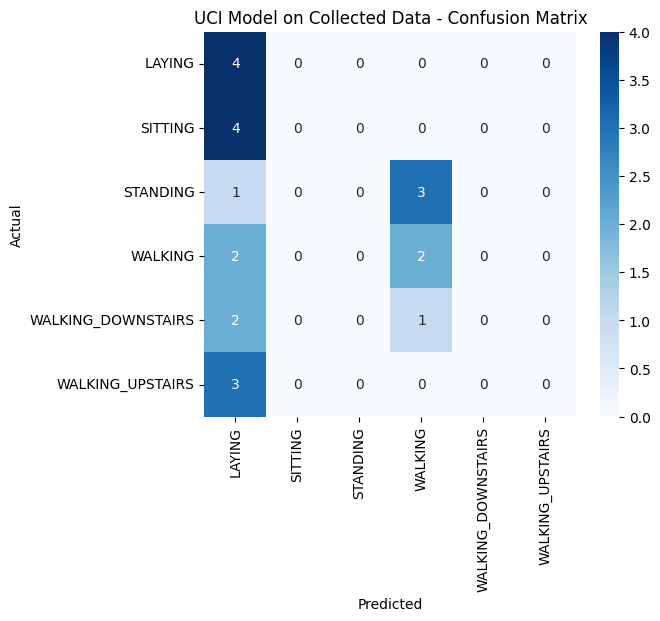

In [61]:
# Question 1: Test UCI-trained models on collected data
print("=== QUESTION 1: UCI MODELS ON COLLECTED DATA ===\n")

if len(X_collected) > 0:
    # Test 1: Raw data model
    y_pred_raw_collected = dt_raw.predict(X_collected)
    acc_raw_collected = accuracy_score(y_collected, y_pred_raw_collected)
    prec_raw, rec_raw, f1_raw, _ = precision_recall_fscore_support(y_collected, y_pred_raw_collected, average='weighted', zero_division=0)
    
    print("1. Raw Data Model:")
    print(f"   Accuracy: {acc_raw_collected:.3f}")
    print(f"   Precision: {prec_raw:.3f}, Recall: {rec_raw:.3f}, F1: {f1_raw:.3f}")
    
    # Test 2: Simple features model (most compatible)
    # Extract simple features from collected data
    X_collected_reshaped = X_collected.reshape(len(X_collected), 500, 3)
    feat_collected = np.array([[seg[:,0].mean(), seg[:,1].mean(), seg[:,2].mean(), 
                               seg[:,0].std(), seg[:,1].std(), seg[:,2].std()] 
                              for seg in X_collected_reshaped])
    
    y_pred_simple_collected = dt_simple.predict(feat_collected)
    acc_simple_collected = accuracy_score(y_collected, y_pred_simple_collected)
    prec_simple, rec_simple, f1_simple, _ = precision_recall_fscore_support(y_collected, y_pred_simple_collected, average='weighted', zero_division=0)
    
    print("\n2. Simple Features Model:")
    print(f"   Accuracy: {acc_simple_collected:.3f}")
    print(f"   Precision: {prec_simple:.3f}, Recall: {rec_simple:.3f}, F1: {f1_simple:.3f}")
    
    # Test 3: TSFEL features model
    if 'dt_tsfel' in globals():
        # Extract TSFEL features from collected data
        tsfel_collected = []
        for i in range(len(X_collected)):
            sample = X_collected[i].reshape(500, 3)
            sample_df = pd.DataFrame(sample, columns=['acc_x', 'acc_y', 'acc_z'])
            try:
                feat = tsfel.time_series_features_extractor(cfg, sample_df, verbose=0)
                tsfel_collected.append(feat.values.flatten())
            except:
                # Use zeros if extraction fails
                tsfel_collected.append(np.zeros(X_tsfel_train.shape[1]))
        
        tsfel_collected = np.array(tsfel_collected)
        
        # Remove non-finite values
        finite_mask = np.isfinite(tsfel_collected).all(axis=1)
        if np.any(finite_mask):
            y_pred_tsfel_collected = dt_tsfel.predict(tsfel_collected[finite_mask])
            y_collected_valid = y_collected[finite_mask]
            
            acc_tsfel_collected = accuracy_score(y_collected_valid, y_pred_tsfel_collected)
            prec_tsfel, rec_tsfel, f1_tsfel, _ = precision_recall_fscore_support(y_collected_valid, y_pred_tsfel_collected, average='weighted', zero_division=0)
            
            print("\n3. TSFEL Features Model:")
            print(f"   Accuracy: {acc_tsfel_collected:.3f}")
            print(f"   Precision: {prec_tsfel:.3f}, Recall: {rec_tsfel:.3f}, F1: {f1_tsfel:.3f}")
        else:
            print("\n3. TSFEL Features Model: Feature extraction failed")
    else:
        print("\n3. TSFEL Features Model: Not available")
    
    # Confusion matrix for best model (tsfel)
    cm_collected = confusion_matrix(y_collected, y_pred_tsfel_collected)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_collected, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('UCI Model on Collected Data - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
else:
    print("No collected data found!")